# Marginal Gaussianization

* Author: J. Emmanuel Johnson
* Email: jemanjohnson34@gmail.com

In this demonstration, we will show how we can do the marginal Gaussianization on a 2D dataset using the Histogram transformation and Inverse CDF Gaussian distribution. 



In [16]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

from rbig.data import ToyData
from rbig.transform.gaussianization import QuantileGaussianization, PowerGaussianization
# from rbig.transform.gaussianization import HistogramGaussianization, KDEGaussianization

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

For this example, we are looking at a 2D dataset.

In [17]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

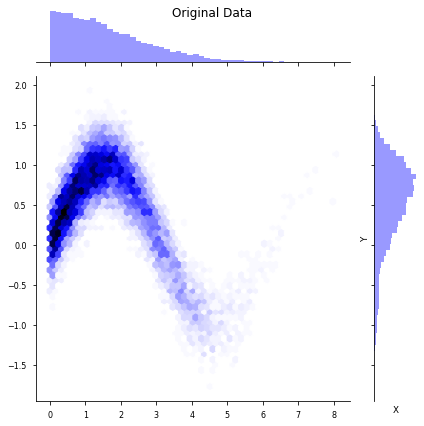

In [18]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
n_features = 2
noise = 0.25
random_state=1
clusters = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state,
    clusters=clusters,
).generate_samples()

X = data[:, 0]
Y = data[:, 1]

plot_2d_joint(data, title='Original Data')

## Quantile Transformer

In [19]:
# parameters
n_quantiles = 1_000   # number of bins to do the histogram transform
subsample = 1e5   # adds some regularization (noise)

# PowerGaussianization
mg_transformer = PowerGaussianization()
# # initialize the transformer
# mg_transformer = QuantileGaussianization(
#     n_quantiles=n_quantiles,
#     subsample=subsample
# )

In [20]:
# fit the transformer to the data
mg_transformer.fit(data);

<Figure size 360x360 with 0 Axes>

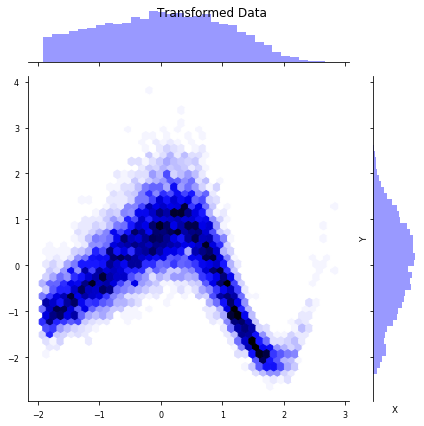

In [21]:
data_trans = mg_transformer.transform(data)

plot_2d_joint(data_trans, title='Transformed Data')

### Inverse Transformation

In [22]:
data_approx = mg_transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_approx, data, decimal=1e-5)

<Figure size 360x360 with 0 Axes>

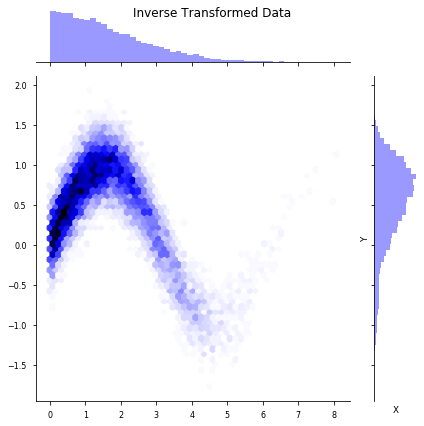

In [23]:
# Plot results
plot_2d_joint(data_approx, title='Inverse Transformed Data')

### Log Determinant Jacobian

In [11]:
X_slogdet = mg_transformer.log_abs_det_jacobian(data)

print(X_slogdet.min(), X_slogdet.max())
print(np.exp(X_slogdet).min(), np.exp(X_slogdet).max())
print(X_slogdet.shape)

-8.125667451357101 -0.9189385410679712
0.0002958472005280255 0.39894227726443043
(10000, 2)


<Figure size 360x360 with 0 Axes>

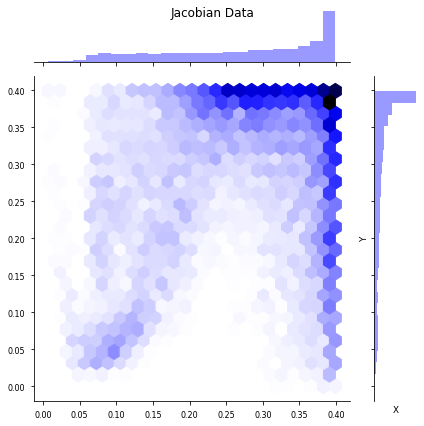

In [12]:
# plot the gradients
plot_2d_joint(np.exp(X_slogdet), title='Jacobian Data')

### Log Probability

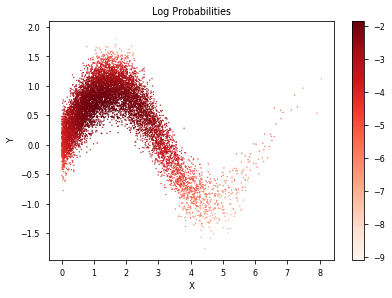

In [13]:
# score samples 
log_prob = mg_transformer.score_samples(data)

plot_prob(data, log_prob, title='Log Probabilities')

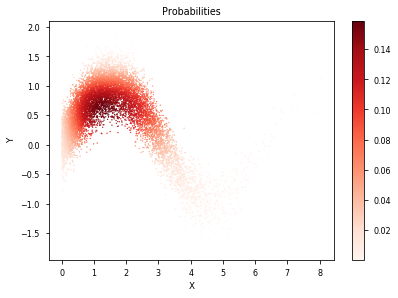

In [14]:
plot_prob(data, np.exp(log_prob), title='Probabilities')

### Negative Log Likelihood

In [15]:
score = mg_transformer.score(data)

print(f"Negative Log-Likelihood Score: {score:.4f}")

Negative Log-Likelihood Score: -2.8379


## Marginal Histogram Transformation

So, for this transformation, we are going to transform our data from the current distribution to a marginally Gaussian distribution and then perform a rotation. In theory, if we do enough of these, we will eventually convert to a Gaussian distribution.

In [5]:
# parameters
nbins = 1_000   # number of bins to do the histogram transform
alpha = 1e-05   # adds some regularization (noise)
support_extension = 10


# initialize the transformer
mg_transformer = HistogramGaussianization(
    nbins=nbins,
    alpha=alpha
)

# fit the transformer to the data
mg_transformer.fit(data);

### 1. Forward Transformation

For this transformation, we will be applying the following:

$$\Psi(\mathbf{x}) = \Phi^{-1}(\mathbf{x})$$

where $\Phi^{-1}(\cdot)$ is the inverse CDF of the Gaussian distribution.

<Figure size 360x360 with 0 Axes>

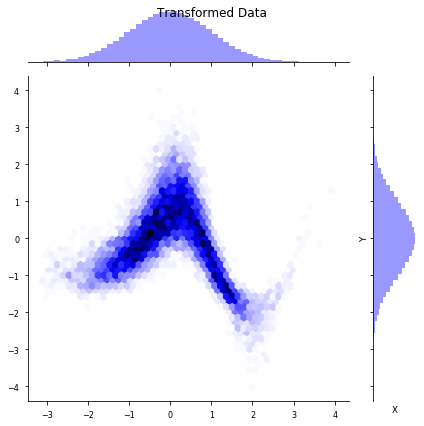

In [6]:
data_trans = mg_transformer.transform(data)

plot_2d_joint(data_trans, title='Transformed Data')

So clearly we can see that the transformation works. Both of the marginals are Gaussian distributed..

### 2. Inverse Transformation

For this step, we will apply the inverse transformation:

$$\Psi^{-1}(\mathbf{x}) = \Phi \left( \mathbf{x} \right)$$

where $\Phi(\cdot)$ is the CDF of the Gaussian distribution.

In [7]:
data_approx = mg_transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_approx, data, decimal=1e-5)

We see that this transformation is very close to the original. In fact, it's close to approximately 1e-5 decimal places. The errors will definitely stem from the boundaries.

<Figure size 360x360 with 0 Axes>

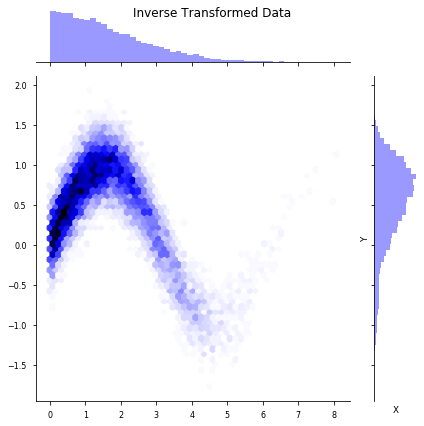

In [8]:
# Plot results
plot_2d_joint(data_approx, title='Inverse Transformed Data')

## Log Absolute Determinant Jacobian

Using the derivative of inverse-functions theorem, we can calculate the derivative like so:

$$\nabla_\mathbf{x} \Phi^{-1}(\mathbf{x}) = \frac{1}{\phi (\Phi^{-1} (x)) }$$

where $\phi(\cdot)$ is the PDF of the Gaussian distribution. Taking the log of these terms gives us:

$$ \log \nabla_\mathbf{x} \Phi^{-1}(\mathbf{x}) = - \log \phi (\Phi^{-1} (x))$$



In [9]:
X_slogdet = mg_transformer.log_abs_det_jacobian(data)

print(X_slogdet.min(), X_slogdet.max())
print(np.exp(X_slogdet).min(), np.exp(X_slogdet).max())

(-2.459695595900522, 5.0787933667391965)

(0.08546096167531662, 160.5801775987935)

<Figure size 360x360 with 0 Axes>

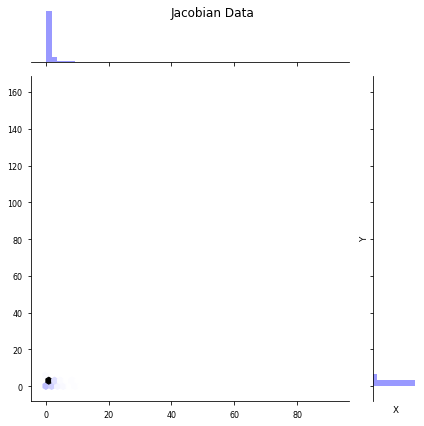

In [12]:
# plot the gradients
plot_2d_joint(np.exp(X_slogdet), title='Jacobian Data')

## Log Probability

$$\log p_\theta(\mathbf{x}) = \log p_\theta \left( \mathbf{z} \right) + \log \left| \nabla_\mathbf{x} \mathbf{z} \right|$$

where $\mathbf{z} = \Psi(\mathbf{x})$


In [13]:
# score samples 
log_prob = mg_transformer.score_samples(data)

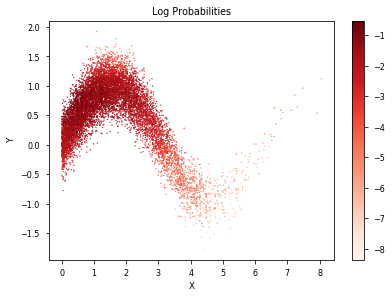

In [14]:
# score samples 
log_prob = mg_transformer.score_samples(data)

plot_prob(data, log_prob, title='Log Probabilities')

## Probability

This is the same as above but without the log scale:

$$p_\theta(\mathbf{x}) = p_\theta \left( \mathbf{z} \right) \left| \nabla_\mathbf{x} \mathbf{z} \right|$$

where $\mathbf{z} = \Psi(\mathbf{x})$

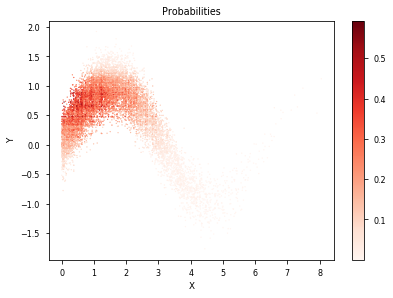

In [15]:
plot_prob(data, np.exp(log_prob), title='Probabilities')

## Negative Log-Likelihood

We need to take the expected value (mean) of all log probabilities.

$$\text{nll} = \frac{1}{N} \sum_{n=1}^{N} \log p_\theta(\mathbf{x})$$

In [16]:
score = mg_transformer.score(data)

print(f"Negative Log-Likelihood Score: {score:.4f}")

Negative Log-Likelihood Score: -2.0724


## KDE Marginal Gaussianization

In [26]:
data.shape

(10000, 2)

In [56]:
# KDE parameters
method = 'knn'
n_quantiles = 1_000
support_extension = 10
bw_estimator = 'scott'

# initialize kde uniformization class
marg_kde_clf = KDEGaussianization(
    method=method,
    n_quantiles=n_quantiles, 
    support_extension=support_extension,
    bw_estimator=bw_estimator
)

# fit to data
marg_kde_clf.fit(data)

KDEGaussianization(algorithm='kd_tree', bw_estimator='scott', kernel='gaussian',
                   kwargs={}, method='knn', metric='euclidean',
                   n_quantiles=1000, support_extension=10)

### Forward Transformation

<Figure size 360x360 with 0 Axes>

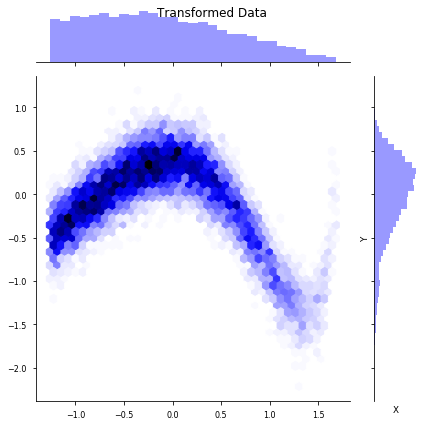

In [57]:
data_trans = marg_kde_clf.transform(data)

plot_2d_joint(data_trans, title='Transformed Data')

### Inverse Transformation

In [58]:
data_approx = marg_kde_clf.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_approx, data, decimal=1e-5)

<Figure size 360x360 with 0 Axes>

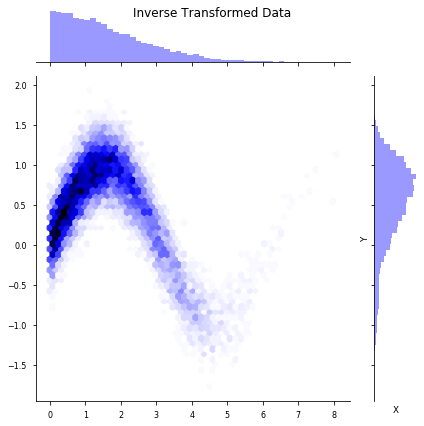

In [59]:
# Plot results
plot_2d_joint(data_approx, title='Inverse Transformed Data')

In [60]:
X_slogdet = marg_kde_clf.log_abs_det_jacobian(data)
print(X_slogdet.min(), X_slogdet.max())
print(np.exp(X_slogdet).min(), np.exp(X_slogdet).max())

-5.100888009023146 0.34758264457205224
0.006091335002667554 1.4156413008498012


<Figure size 360x360 with 0 Axes>

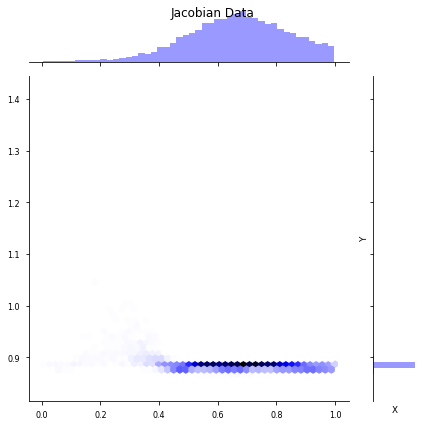

In [61]:
# plot the gradients
plot_2d_joint(np.exp(X_slogdet), title='Jacobian Data')

### Log Probability

In [62]:
# score samples 
log_prob = marg_kde_clf.score_samples(data)

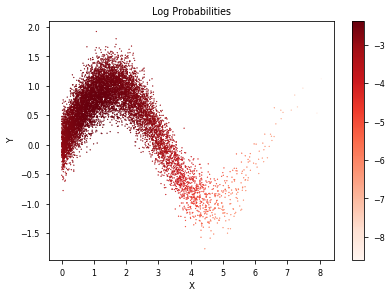

In [63]:
plot_prob(data, log_prob, title='Log Probabilities')

### Probability

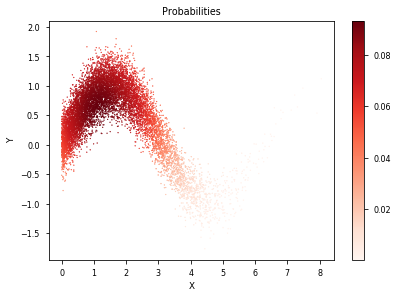

In [64]:
plot_prob(data, np.exp(log_prob), title='Probabilities')

### Negative Loglikelihood

In [65]:
score = marg_kde_clf.score(data)

print(f"Negative Log-Likelihood Score: {score:.4f}")

Negative Log-Likelihood Score: -2.7892
